In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.optimize as so
import scipy.linalg as sl
import scipy.integrate as si
import matplotlib.pyplot as plt
from numba import njit

<h3>Generate Training Data</h3>

**In other words, solve the forward problem**

In [2]:
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:] that could be
    # strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

In [3]:
# set number of Fourier basis functions to use
# for Fourier representation of the TDSE
nfb = 128

# set radius of spatial domain
r = 16

# create vector of real space points for plotting
nrs = 1024
xvec = np.linspace(-r, r, nrs)

In [4]:
# this code constructs elements needed for plotting

# construct matrix to convert Fourier basis coefficients 
# into real space values
nvec = np.arange(-nfb, nfb+1) # nvec=-nfb,...,0,...,nfb
convmat = np.exp(1j * np.pi * np.outer(nvec, xvec) / r) / np.sqrt(2*r)

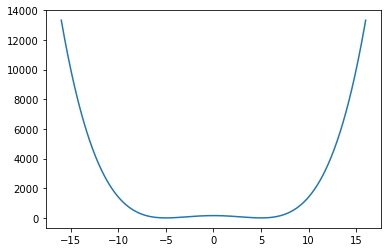

In [5]:
# define test potential for generating simulated observations

# symmetric double well potential
def v(x):
    return 0.25*(x**2 - 25)**2

# dimensionless quantum harmonic oscillator potential
# def v(x):
#     return 0.5*x**2

vtrue = v(xvec)
plt.plot(xvec, vtrue)
plt.show()

---

Let
$$
g(x; \alpha, \beta) = e^{-\alpha(x-\beta)^2}
$$
Then we need to first convert the potential function to the Gaussian basis
$$
v(x)\rightarrow v(x)\approx \sum c_i g(x; \alpha, \beta)
$$

Let $c$ be the vector of basis coefficients and $B$ be the matrix defined as
$$
G=\begin{pmatrix}
g(x_0; \alpha, \beta_0) & g(x_0; \alpha, \beta_1) & \dots \\
g(x_1; \alpha, \beta_0) & g(x_1; \alpha, \beta_1) & \dots \\
\vdots
\end{pmatrix}
$$
so
$$
\{v(x_i)\} \approx G c
$$
Therefore, to compute $c$, we multiply both sides of the above equation (on the left) by the inverse of $B$
$$
G^{-1} \{v(x_i)\} \approx G^{-1} G c
$$
which results in
$$
G^{-1} \{v(x_i)\} = c
$$


Given $c$ and $k_h = \pi h / a$ we can get the potential vector (which is tranformed into the Toeplitz matrix) with
$$
V_h = \frac{1}{2 a} \sqrt{\frac{\pi}{\alpha}} e^{-\frac{k_h^2}{4 \alpha}} \sum_j e^{-i k_h \beta_j} c_j 
$$
The sum can be computed using matrix-vector multiplication. Let
$$
M = \begin{pmatrix}
e^{-i k_0 \beta_0} & e^{-i k_0 \beta_1} & \dots \\
e^{-i k_1 \beta_0} & e^{-i k_1 \beta_1} & \dots \\
\vdots
\end{pmatrix}
$$
then $\sum_j e^{-i k_h \beta_j} c_j$ for all $k_h$ is $M c$.


If we define the constant vector $f$ as
$$
f = \begin{pmatrix}
e^{-\frac{k_0^2}{4 \alpha}} & e^{-\frac{k_1^2}{4 \alpha}} & \dots
\end{pmatrix}^T
$$
then we can calculate the vector $V_h$ all at once by
$$
V = \frac{1}{2 a} \sqrt{\frac{\pi}{\alpha}} f M c
$$

In [6]:
# this code computes the coefficents of the potential function in the
# Gaussian basis

ng = 16
xg = np.linspace(-r, r, ng)

In [7]:
def grecnorm(alpha):
    gmat = np.exp(-alpha * (xg[:,np.newaxis] - xg)**2)
    gmatplot = np.exp(-alpha * (xvec[:,np.newaxis] - xg)**2)

    # compute coefficents of the potential function in the Gaussian basis
    # the inversed matrix must be squarea
    coeffs = nl.inv(gmat) @ v(xg)

    # reconstruct the potential from the Gaussian basis coefficents
    reconv = gmatplot @ coeffs

    # quantify difference between real and reconstructed potentials
    return nl.norm(reconv - vtrue)

In [8]:
y=[]
for i in np.arange(.0001, 10, 0.01):
    y.append(grecnorm(i))
print('Done.')

Done.


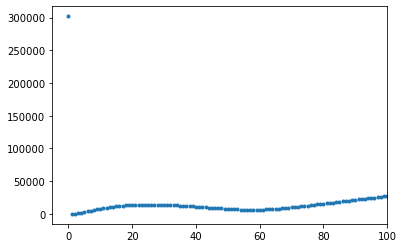

In [9]:
plt.plot(y, '.')
#plt.ylim((-5,40))
plt.xlim((-5,100))
plt.show()

In [10]:
# for ng=16, x0=0.4
# for ng=256, x0=100
minalpha = so.minimize(grecnorm, x0=0.4, options={'disp': True}).x
print(minalpha)

Optimization terminated successfully.
         Current function value: 6206.656058
         Iterations: 7
         Function evaluations: 34
         Gradient evaluations: 17
[0.57693452]


(16, 16)
(1024, 16)


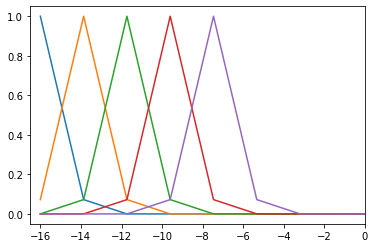

(16,)


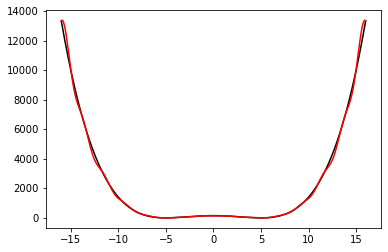

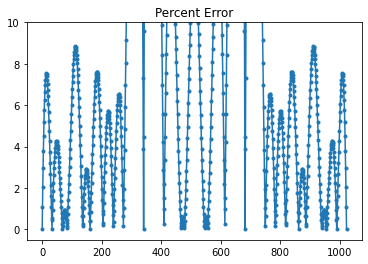

In [11]:
# this code computes the coefficents of the potential function in the
# Gaussian basis

gmat = np.exp(-minalpha * (xg[:,np.newaxis] - xg)**2)
print(gmat.shape)

gmatplot = np.exp(-minalpha * (xvec[:,np.newaxis] - xg)**2)
print(gmatplot.shape)

# show first 5 basis to check overlap 
for i in range(5):
    plt.plot(xg, np.exp(-minalpha * (xg - xg[i])**2))
plt.xlim((-r-0.5, 0))
plt.show()

# compute coefficents of the potential function in the Gaussian basis
# the inversed matrix must be squarea
cfftrue = nl.inv(gmat) @ v(xg)
print(cfftrue.shape)

# reconstruct the potential from the Gaussian basis coefficents
reconv = gmatplot @ cfftrue

# plot real potential vs. reconstructed potential
plt.plot(xvec, vtrue, 'k')
plt.plot(xvec, reconv, 'r')
plt.show()

# quantify difference between real and reconstructed potentials
# NEED WAY TO CALCULATE PERCENT ERROR WHEN TRUE VALUE IS ZERO
plt.plot(100 * np.abs(reconv - vtrue) / vtrue, '.-')
plt.ylim((-0.5, 10))
plt.title('Percent Error')
plt.show()

In [12]:
# this code computes the potential matrix in the Fourier basis
# given a potential in the Gaussian basis
# cff is the vector of coefficents in the Gaussian basis

k = np.pi * np.arange(0, 2*nfb+1) / r
expmat = np.exp((-k**2 / (4*minalpha))[:, np.newaxis] + (-1j*k[:,np.newaxis]*xg))
gvmattrm = (1/(2*r)) * np.sqrt(np.pi/minalpha) * expmat

gradgvmat = np.zeros((ng, 2*nfb+1, 2*nfb+1), dtype=np.complex128)
for i in range(ng):
    thisgvmattrm = gvmattrm.T[i]
    gradgvmat[i,:]=toeplitz(thisgvmattrm.conj(), thisgvmattrm)
print(gradgvmat.shape)

@njit
def gvmat(cff):
    column =  gvmattrm @ cff.astype(np.complex128)
    row = column.conj()
    return toeplitz(r=row, c=column)

(16, 257, 257)


In [13]:
# construct true potential matrix
vmattrue = gvmat(cfftrue)
print(vmattrue.shape)

(257, 257)


In [14]:
# this code constructions the Hamiltonian matrix
# and performs the eigendecomposition on it

# construct kinetic matrix
kmat = np.diag(np.arange(-nfb,nfb+1)**2 * np.pi**2 / (2*r**2))

# construct Hamiltonian matrix
hmattrue = kmat + vmattrue

# check if the Hamiltonian matrix is Hermitian
print(nl.norm(hmattrue - hmattrue.T.conj()))

# diagonalize hmat matrix (i.e. eigendecomposition)
# eigenspectrum / eigensates
spectrue, statetrue = nl.eigh(hmattrue)

# check if eigval / eigsta diagonalizes hmat
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print(nl.norm(hmattrue @ statetrue - statetrue @ np.diag(spectrue)))

# check if the eigenstates are unitary
print(nl.norm(statetrue @ statetrue.T.conj() - np.eye(2*nfb+1)))

0.0
1.5669856276918858e-10
3.460660771122223e-14


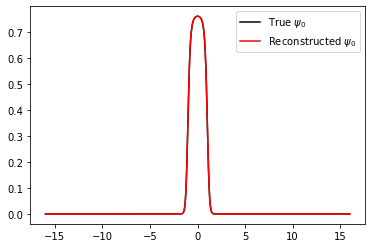

0.00028386310807257967


In [15]:
# this code creates the initial wave function psi0

# rounded box function
def psi0(x):
    return 1.0 + np.tanh((1 - x**2)/0.5)

# normalize psi0
norm = np.sqrt(si.quad(lambda x: np.abs(psi0(x))**2, a=-r, b=r)[0])
def normpsi0(x):
    return psi0(x)/norm

# transform psi0 to Fourier basis using quadrature method
# do this by stepping through and integrating for each n
vraw = np.zeros(nfb+1, dtype=np.complex128)
for thisn in range(nfb+1):
    def integ(x):
        return (2*r)**(-0.5)*np.exp(-1j*np.pi*thisn*x/r)*normpsi0(x)
    def rinteg(x):
        return np.real(integ(x))
    def iinteg(x):
        return np.imag(integ(x))
    vraw[thisn] = si.quad(rinteg, a=-r, b=r)[0] + 1j*si.quad(iinteg, a=-r, b=r)[0]
ainit = np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw])

# check if the reconstructed psi0 is "close enough" to the true psi0
plt.plot(xvec, normpsi0(xvec), color='black', label=r"True $\psi_0$")
psi0recon = np.real(ainit @ convmat)
plt.plot(xvec, psi0recon, color='red', label=r"Reconstructed $\psi_0$")
plt.legend()
plt.show()

# quantify difference between reconstructed psi0 and true psi0 
print(nl.norm(normpsi0(xvec) - psi0recon))

**Propagate psi0 with hamtrue to Generate Training Data**

In [16]:
# set the time step size for propagating
dt = 0.01

# set the number of steps to propagate "a" vector in time
nsteps = 200


In [17]:
# this code generates the training data by propagating the "a" vector
# of coefficients using the eigendecomposition from above

# compute the propagator matrix using eigval & eigsta
propmat = statetrue @ np.diag(np.exp(-1j * spectrue * dt)) @ statetrue.T.conj()

# initialize matrix to store time series data for "a" vector 
amattrue = np.zeros((nsteps+1, 2*nfb+1), dtype=np.complex128)
amattrue[0, :] = ainit.copy()

# propagate "a" vector using propmat
for j in range(nsteps):
    amattrue[j+1,:] = propmat @ amattrue[j,:]
    
# transform amat to real space
psimattrue = amattrue @ convmat

# check that wave function is normalized for every time step
psimattruenorm = np.sqrt(np.sum(np.abs(amattrue)**2, axis=1))
print(psimattruenorm)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<h3>Inverse Problem</h3>

**Code for Propagating System with Predicted Potential**

In [18]:
# this code propagates the a/ahat vector using a Hamiltonian which
# depends on the modeling paramters theta/thetahat

# number of elements for toeplitz representation
m = 2*nfb + 1

@njit
def prop(x):
    # compute potential matrix using model paramters
    vhatmat = gvmat(x)

    # Hamiltonian matrix 
    hhatmat = kmat + vhatmat

    # eigendecomposition and compute propagator
    hatspec, hatstates = np.linalg.eigh(hhatmat)
    hatprop = hatstates @ np.diag(np.exp(-1j*hatspec*dt)) @ np.conj(hatstates.T)
    hatpropH = hatstates @ np.diag(np.exp(1j*hatspec*dt)) @ np.conj(hatstates.T)

    # propagate the ahat vector of coefficients, i.e., solve the *forward* problem
    ahatmat = np.zeros((nsteps+1, 2*nfb+1), dtype=np.complex128)
    ahatmat[0,:] = np.copy(ainit)
    for j in range(nsteps):
        ahatmat[j+1,:] = hatprop @ ahatmat[j,:]

    # propagating the lambda vector backward in time, i.e., solve the *adjoint* problem
    lambmat = np.zeros((nsteps+1, 2*nfb+1), dtype=np.complex128)
    lambmat[nsteps,:] = ahatmat[nsteps,:] - amattrue[nsteps,:]
    for j in range(nsteps-1,0,-1):
        lambmat[j,:] = ahatmat[j,:] - amattrue[j,:] + hatpropH @ lambmat[j+1,:]
    
    return hatspec, hatstates, ahatmat, lambmat, hatprop, hatpropH


In [19]:
# compute the Lagrangian
# the input x is the vector of modeling parameters (theta or thetahat)

@njit
def laghelp(x, ahatmat):
    # compute lagrangian
    resid = ahatmat - amattrue
    lag = 0.5*np.real(np.sum(np.conj(resid)*resid))
    return lag

laghistlen = 20
laghist = np.zeros(laghistlen)
itercnt = 0

def justlag(x):
    global laghist, laghistpsn
    global glbhatspec, glbhatstates, glbahatmat, glblambmat
    global glbhatprop, glbhatpropH
    global itercnt
    
    # propagate system
    glbhatspec, glbhatstates, glbahatmat, glblambmat, glbhatprop, glbhatpropH = prop(x)
    
    # compute Lagrange
    lag = laghelp(x, glbahatmat)
    itercnt += 1

    # roll the history back one and replace with newest value
    # i.e. put newest value on the end of the stack
    laghist = np.roll(laghist, -1)
    laghist[-1] = lag
    
    # print the last 5 values of laghist
    # print(f'{itercnt} Lagrangan={laghist[-5:]}', end='\r')
    # print(f'{itercnt} Lagrangan={laghist[-1]}', end='\r')
    return lag
    

In [20]:
# compute the gradients
# the input x is the vector of modeling parameters (theta or thetahat)

@njit
def gradhelp(x, hatspec, hatstates, ahatmat, lambmat, derivamat):
    alldmat = np.zeros((ng, m, m), dtype=np.complex128)
    expspec = np.exp(-1j*dt*hatspec)
    mask = np.zeros((m,m), dtype=np.complex128)
    for ii in range(m):
        for jj in range(m):
            if np.abs(hatspec[ii] - hatspec[jj]) < 1e-8:
                mask[ii,ii] = expspec[ii]
            else:
                mask[ii,jj] = (expspec[ii] - expspec[jj])/(-1j*dt*(hatspec[ii]-hatspec[jj]))
    
    for iii in range(ng):
        thisA = hatstates.conj().T @ gradgvmat[iii] @ hatstates
        qmat = thisA * mask
        alldmat[iii,:,:] = -1j*dt* hatstates @ qmat @ hatstates.conj().T

    return alldmat
        
def justgrad(x):
    global glbhatspec, glbhatstates, glbahatmat, glblambmat
    global glballdmat, glbderivamat
    glbderivamat = np.zeros((2*m-1, m, m), dtype=np.complex128)
    
    # compute alldmat
    glballdmat = gradhelp(x, glbhatspec, glbhatstates, glbahatmat, glblambmat, glbderivamat)
    # compute all entries of the gradient at once
    gradients = np.real(np.einsum('ij,ajk,ik->a', np.conj(glblambmat[1:,:]), glballdmat, glbahatmat[:-1,:]))
    print(itercnt, 'Grad norm:', nl.norm(gradients), end='\r')
    return gradients

**Check Functions Using True $\theta$**

In [21]:
# check if the Lagrangian of the true theta, xtrue, gives 0
# justlag(xtrue)
justlag(cfftrue)

0.0

In [22]:
# check if the gradient of the Lagrangian is zero for the true theta, xtrue
#justgrad(xtrue)
justgrad(cfftrue)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

**Initialize theta with true theta pertubed by random normally distributed noise**

In [23]:
# easy test case: initialize theta with true theta pertubed random normally
# distributed noise with small variance. This should be easy for the optimizer
# to converge to a good minimum
cfftrub = cfftrue.copy()
cfftrub += 0.25*np.random.normal(size=cfftrue.shape)

In [24]:
print(cfftrub.shape)

(16,)


In [25]:
laghist = np.zeros(laghistlen)
itercnt = 0
restrub = so.minimize(justlag, cfftrub, jac=justgrad,
                      options={'maxiter': 5, 'disp': True}) 

         Current function value: 0.001392
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9


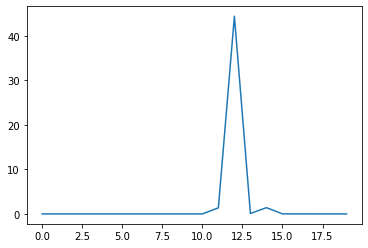

In [26]:
plt.plot(laghist)
plt.show()

In [27]:
# check value of Lagrangian at computed value of theta
print(justlag(restrub.x))

# check how close predicted coefficents are to
# the coefficents used to make the training data
print(nl.norm(restrub.x - cfftrue))

0.001392117309041067
0.8154277630918443


Prediction vs. Truth:  6207.25263279975
Prediction vs. Training:  5.48592191808139


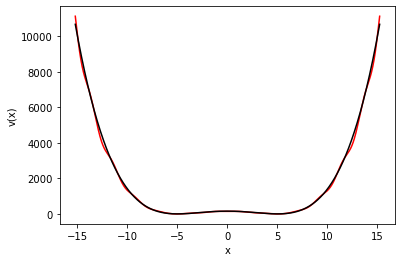

In [28]:
# this code plots the estimated potential against the true potential

# use the machine learned prediction to compute the predicted potential
vturbprdc = gmatplot @ restrub.x

# quantify how close the predicted potential to true potential
print('Prediction vs. Truth: ', nl.norm(vtrue - vturbprdc))

# quantify how close the predicted potential is to the training data
print('Prediction vs. Training: ', nl.norm(reconv - vturbprdc))

# plot the real part of theta
# red = learned potential
# black = true potential
trim = 25
plt.plot(xvec[trim:-trim], vturbprdc[trim:-trim], color='red')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black')
plt.xlabel('x')
plt.ylabel('v(x)')
plt.show()

**Initialize theta with uniform random values**

In [29]:
# uniform random values from the interval [-0.5, 0.5]
# this should be difficult for the optimizer to find a good minimum

cffform = np.random.uniform(size=cfftrue.shape) - 0.5

laghist = np.zeros(laghistlen)
itercnt = 0
resform = so.minimize(justlag, cffform, jac=justgrad,
                      # options={'maxiter': 1000, 'disp': True})
                      options={'maxiter': 1000, 'disp': True, 'norm': 1e-10}, method='BFGS')

/Users/morty/miniforge3/envs/work1221/lib/python3.9/site-packages/scipy/optimize/optimize.py:170: RuntimeWarning: overflow encountered in double_scalars
  return np.sum(np.abs(x)**ord, axis=0)**(1.0 / ord)


         Current function value: 199.987971
         Iterations: 154
         Function evaluations: 194
         Gradient evaluations: 183


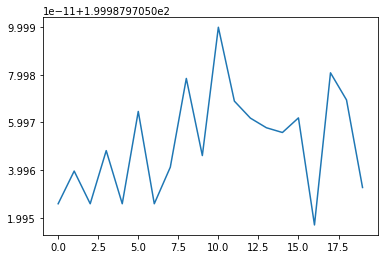

In [33]:
plt.plot(laghist)
plt.show()

Last value of Lagrange:  199.98797050003265
Coefficients:  20477.128986130574
Prediction vs. Truth:  135007.6093987803
Prediction vs. Training:  136590.80574227948


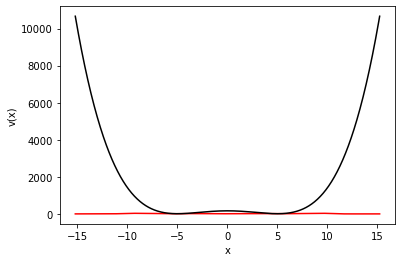

In [34]:
# results

# check value of Lagrangian at computed value of theta
print('Last value of Lagrange: ', justlag(resform.x))

# check how close predicted coefficents are to
# the coefficents used to make the training data
print('Coefficients: ', nl.norm(resform.x - cfftrue))

# use the machine learned prediction to compute the predicted potential
vformprdc = gmatplot @ resform.x

# quantify how close the predicted potential to true potential
print('Prediction vs. Truth: ', nl.norm(vtrue - vformprdc))

# quantify how close the predicted potential is to the training data
print('Prediction vs. Training: ', nl.norm(reconv - vformprdc))

# plot the real part of theta
# red = learned potential
# black = true potential
trim = 25
plt.plot(xvec[trim:-trim], vformprdc[trim:-trim], color='red')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black')
plt.xlabel('x')
plt.ylabel('v(x)')
plt.show()

0.0
4.46923067788682e-12
3.778525932086358e-14
Element difference:
 [0.00356096+0.00830883j 0.00351719+0.00796422j 0.00321875+0.00674102j ...
 0.002897  +0.00630788j 0.00334941+0.00773476j 0.00356096+0.00830883j]
Norm of difference: 113.07845075323473


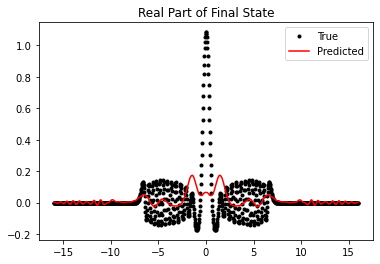

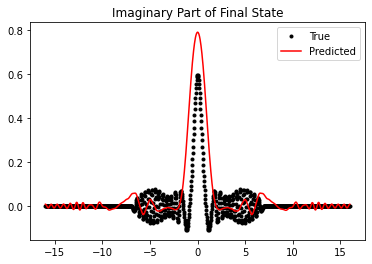

In [35]:
# propagate psi0 using the predicted potential

vmatprdt = gvmat(resform.x)

hmatprdt = kmat + vmatprdt

# check if the Hamiltonian matrix is Hermitian
print(nl.norm(hmatprdt - hmatprdt.T.conj()))

# diagonalize hmat matrix (i.e. eigendecomposition)
specprdt, stateprdt = nl.eigh(hmatprdt)

# check if eigval / eigsta diagonalizes hmat
print(nl.norm(hmatprdt @ stateprdt - stateprdt @ np.diag(specprdt)))

# check if the eigenstates are unitary
print(nl.norm(stateprdt @ stateprdt.T.conj() - np.eye(2*nfb+1)))

# compute the propagator matrix using eigval & eigsta
propmat = stateprdt @ np.diag(np.exp(-1j * specprdt * dt)) @ stateprdt.T.conj()

# initialize matrix to store time series data for "a" vector 
amatprdt = np.zeros((nsteps+1, 2*nfb+1), dtype=np.complex128)
amatprdt[0, :] = ainit.copy()

# propagate "a" vector using propmat
for j in range(nsteps):
    amatprdt[j+1,:] = propmat @ amatprdt[j,:]
    
# transform amat to real space
psimatprdt = amatprdt @ convmat

print('Element difference:\n', psimatprdt[-1] - psimattrue[-1])
print('Norm of difference:', nl.norm(psimatprdt - psimattrue))

plt.plot(xvec, psimattrue[-1].real, 'k.', label='True')
plt.plot(xvec, psimatprdt[-1].real, 'r', label='Predicted')
plt.legend()
plt.title('Real Part of Final State')
plt.show()

plt.plot(xvec, psimattrue[-1].imag, 'k.', label='True')
plt.plot(xvec, psimatprdt[-1].imag, 'r', label='Predicted')
plt.legend()
plt.title('Imaginary Part of Final State')
plt.show()


